In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast
from scipy.stats import spearmanr, kstest


In [2]:
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('ComVar_Quarentena.csv')


df['date'] = pd.to_datetime(df.date)
df['open_date'] = pd.to_datetime(df.open_date)

df = df.set_index('open_date').loc['2019-01-01':].reset_index()

df['days_open'] = df['days_open'].astype(float)
df['stock1'] = [pair.split("'")[1] for pair in df.pair]

<ipython-input-3-a27d1f30bd85>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.set_index('open_date').loc['2019-01-01':].reset_index()


In [4]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')

df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [5]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [6]:
df.loc[df['residual_open'] < df['std_open_residual'], 'side'] = 'lower'
df.loc[df['residual_open'] > df['std_open_residual'], 'side'] = 'upper'

In [7]:
returns_list = []
i=1
closed = df.loc[df.status=='close']

for row in closed.itertuples():

    historico_par = df.loc[(df.pair==row.pair) & (df.date.between(row.open_date,row.date))].copy()
    historico_par.set_index('date', inplace=True)
    historico_par['id'] = i
    
    
#     display(historico_par)
#     Custo entrada: 1,22% + 0,1% = 1,31%
#     Custo saida: 1,22% + 0,25% + 0,1% = 1,57% + Aluguel
    
#     display(historico_par)
    aluguel = (1.0143)**((row.days_open+2)/252) -1
    try:
        if row.side == 'lower':
            
            historico_par['ratio_sem_custos'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
            
            # Entrada
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1-0.0071)
            
                    
            # Saída
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
        else:
            
            historico_par['ratio_sem_custos'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
            
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock']
            # Entrada
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1-0.0071)

            # Saida
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
        
        
        historico_par['open_price_first_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
        historico_par['open_price_scnd_stock'] = historico_par.at[row.open_date, 'price_scnd_stock']
        
        historico_par['return'] = (historico_par.ratio / historico_par.ratio.shift(1)) -1
        historico_par['retorno_acumulado'] = np.cumprod(1+historico_par['return']) -1
        
        historico_par['return_sem_custos'] = (historico_par.ratio_sem_custos / historico_par.ratio_sem_custos.shift(1)) -1
        historico_par['retorno_acumulado_sem_custos'] = (np.cumprod(1+historico_par['return_sem_custos']) -1)
        
        returns_list.append(historico_par)
        
    except Exception as e:
#         print(e)
        pass
    
    i+=1

In [8]:
def result_calculator(row, kind='CN'):
    
    if kind=='CN':
        multiplier = 1
    if kind == 'BN':
        multiplier = row.beta_open
    
    if row['residual_open'] < row['std_open_residual']:
        long_result =(row['price_fst_stock'] / row['open_price_first_stock'])
        short_result = (row['open_price_scnd_stock'] / row['price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1
        
        return result, 'lower'
    
    elif row['residual_open'] > row['std_open_residual']:
        long_result = (row['open_price_first_stock'] / row['price_fst_stock'])
        short_result = (row['price_scnd_stock'] / row['open_price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1

        return result, 'upper'

In [9]:
df_returns = pd.concat(returns_list)
df_returns.reset_index(inplace=True)

In [10]:
log_retorno = np.log(1+df_returns.set_index(['date', 'pair', 'open_date','status'])[['return', 'return_sem_custos']]).fillna(0)
retorno_acumulado =  np.exp(log_retorno.cumsum()) - 1
retorno_acumulado.reset_index(inplace=True)

In [11]:
df_returns.halflife.mean()

8.242048517520216

In [12]:
closed = df_returns.loc[df_returns.status=='close']

In [13]:
ibov = pd.read_csv('ibov.csv', usecols=[0,4], index_col=0)
ibov.index = pd.to_datetime(ibov.index)
ibov = ibov.loc[df_returns.date.min():df_returns.date.max()]

In [14]:
log_ret_ibov = np.log(ibov/ibov.shift())
ibov_return = ibov/ibov.shift() -1
ibov_retornos = ibov/ibov.shift() -1
cumsum_ibov = np.cumsum(log_ret_ibov)
ibov_pct = np.exp(cumsum_ibov) -1

In [15]:
# Retorno com custos
acumulado_com_custos = np.cumprod(1+df_returns.groupby('date').sum()['return']) -1

In [16]:
# Resultado sem custos por dia
acumulado_sem_custo = np.cumprod(1+df_returns.groupby('date').sum().return_sem_custos) -1


In [17]:
# Operações Fechadas
fechadas = df_returns.loc[df_returns.status=='close']

fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0

retorno_diario = df_returns.groupby('date').sum()

<ipython-input-17-902cf3657bf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
<ipython-input-17-902cf3657bf9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0


# Graficos

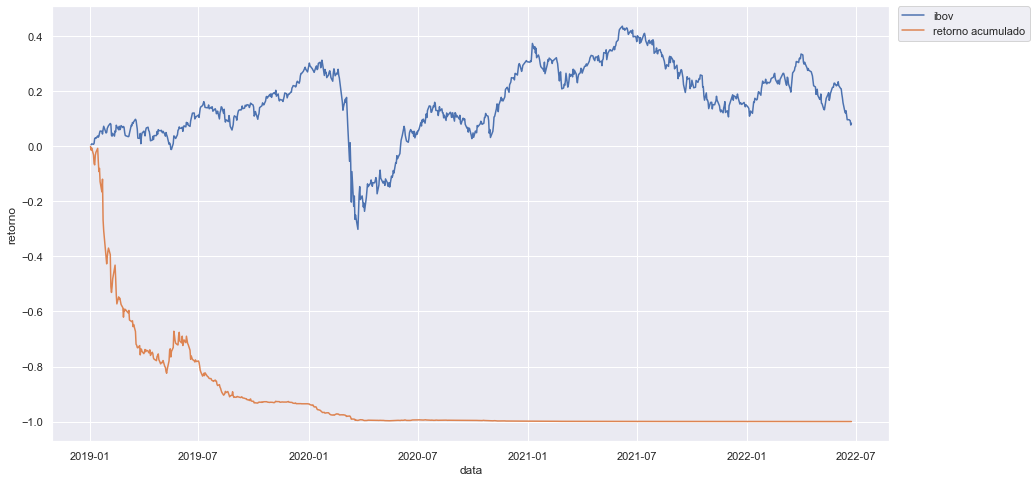

In [18]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_com_custos.index, y=acumulado_com_custos, label='retorno acumulado')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# sns.lineplot(x=cumsum_result_BN.index, y=cumsum_result_BN, label='cointegration beta neutral')


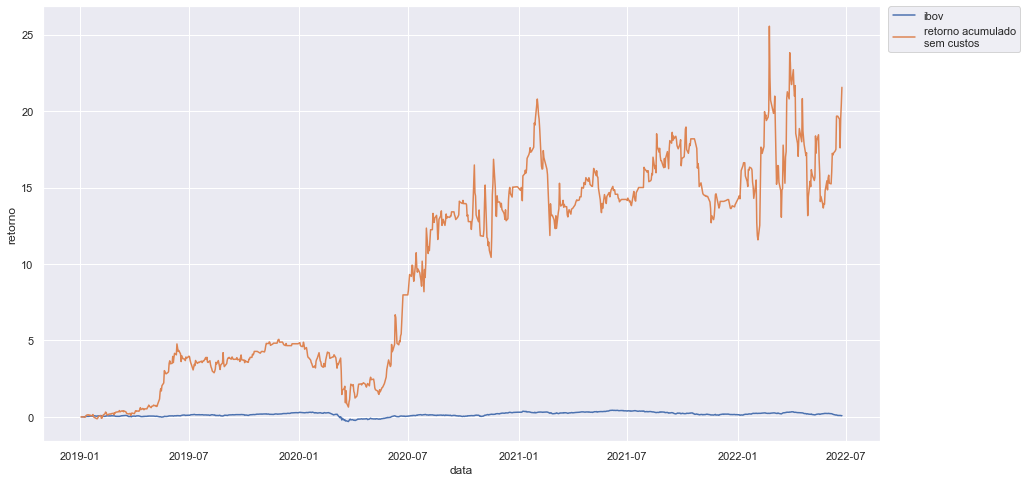

In [19]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_sem_custo.index, y=acumulado_sem_custo, label='retorno acumulado\nsem custos')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [20]:
retornos_diarios = pd.concat([ibov_return, retorno_diario[['return', 'return_sem_custos']]], axis=1)
retornos_diarios.fillna(0, inplace=True)
retornos_diarios.columns = ['ibov', 'retorno_com_custos', 'retorno_sem_custos']

In [21]:
log_retornos = np.log(1+retornos_diarios)
retornos_acumulados = np.exp(log_retornos.cumsum()) -1
retornos_acumulados

,ibov,retorno_com_custos,retorno_sem_custos
2019-01-02,0.000000,0.000000,0.000000
2019-01-03,0.006065,-0.013558,0.000550
2019-01-04,0.009109,-0.005673,0.008547
2019-01-07,0.007548,-0.030467,-0.002651
2019-01-08,0.011207,-0.062533,-0.021626
...,...,...,...
2022-06-20,0.097141,-0.999993,19.469733
2022-06-21,0.095295,-0.999993,17.590915
2022-06-22,0.093504,-0.999993,19.552185
2022-06-23,0.077660,-0.999993,20.419645


# Descritivas

In [22]:
retornos_diarios.describe()

,ibov,retorno_com_custos,retorno_sem_custos
count,864.000000,864.000000,864.000000
mean,0.000262,-0.011294,0.005727
std,0.018215,0.065423,0.065236
min,-0.147797,-0.421534,-0.384249
25%,-0.007783,-0.037183,-0.020936
50%,0.000817,-0.007375,0.000000
75%,0.009629,0.013808,0.024935
max,0.139082,0.363511,0.408877


In [23]:
coeficiente_liquido, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_com_custos']])
print('Correlação de Spearman Resutado líquido: {:0.3}'.format(coeficiente_liquido))

Correlação de Spearman Resutado líquido: 0.109


In [24]:
coeficiente_bruto, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_sem_custos']])
print('Correlação de Spearman Resutado bruto: {:0.3}'.format(coeficiente_bruto))

Correlação de Spearman Resutado bruto: 0.113


In [25]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_sem_custos, 'norm')

KstestResult(statistic=0.43113665549787816, pvalue=1.9646877390058218e-146)

In [26]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_com_custos, 'norm')

KstestResult(statistic=0.42665831270588983, pvalue=2.847798568091724e-143)

In [27]:
df_returns['return'].describe()

count    3199.000000
mean       -0.003050
std         0.027318
min        -0.242895
25%        -0.015432
50%        -0.002869
75%         0.009401
max         0.238407
Name: return, dtype: float64

In [28]:
df_returns['return_sem_custos'].describe()

count    3199.000000
mean        0.001547
std         0.027186
min        -0.242895
25%        -0.011080
50%         0.000724
75%         0.012757
max         0.256469
Name: return_sem_custos, dtype: float64

# Eficacia

In [29]:
eficacia = fechadas.set_index('open_date').resample('6M').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)

eficacia

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-01-31,18,0.611111,5.833333
2019-07-31,105,0.647619,7.447619
2020-01-31,54,0.537037,6.333333
2020-07-31,96,0.552083,5.104167
2021-01-31,58,0.603448,6.482759
2021-07-31,46,0.543478,6.782609
2022-01-31,49,0.510204,5.857143
2022-07-31,85,0.564706,6.094118


# Desempenho

In [30]:
vol_ibov = log_ret_ibov.close.std() * math.sqrt(252)
vol_ibov

0.2930617527924815

In [31]:
log_return = np.log(1+retorno_diario['return'])
vol_return = log_return.std() * math.sqrt(252)
vol_return

1.1089793673992767

In [32]:
log_return_sem_custo = np.log(1+retorno_diario['return_sem_custos'])
vol_return_sem_custo = log_return_sem_custo.std() * math.sqrt(252)
vol_return_sem_custo

1.060952360197953

In [33]:
retorno_acumulado_bruto = retorno_acumulado['return_sem_custos'].iloc[-1]
taxa_acerto = fechadas['e_lucro_bruto'].mean()
retorno_acumulado_liquido = retorno_acumulado['return'].iloc[-1]

desempenho = pd.DataFrame([{
    'retorno_acumulado_bruto':retorno_acumulado_bruto,
    'taxa_acerto': taxa_acerto,
    'retorno_acumulado_liquido': retorno_acumulado_liquido,
    'desvio_padrao': vol_return,
    'sharpe': retorno_acumulado_liquido/vol_return,
    'correlacao_ibov': coeficiente_liquido
    }])

desempenho

,retorno_acumulado_bruto,taxa_acerto,retorno_acumulado_liquido,desvio_padrao,sharpe,correlacao_ibov
0,42.536727,0.575342,-0.999983,1.108979,-0.901715,0.109324


In [34]:
fechadas.groupby('setor').agg('sum')

,price_fst_stock,price_scnd_stock,beta_open,last_residual,std_residual,std_open_residual,residual_open,open_price_first_stock,open_price_scnd_stock,close_limit,...,var_limit,id,ratio_sem_custos,ratio,return,retorno_acumulado,return_sem_custos,retorno_acumulado_sem_custos,e_lucro_bruto,e_lucro_liquido
setor,,,,,,,,,,,,,,,,,,,,,
Alimentos e Bebidas,131.255904,143.264297,8.492752,-20.571493,12.689605,11.869967,-9.362041,145.632609,142.731268,5.934984,...,-0.321289,1726,6.409265,6.315459,-0.126516,-0.214901,-0.024267,-0.015499,4,4
Aéreas,299.045422,242.515998,6.144519,12.849180,10.316754,9.808664,4.158747,285.478683,239.342602,4.904332,...,-0.252653,1243,5.370313,5.292343,-0.235963,-0.275014,-0.122677,-0.078325,3,1
Bens Industriais,187.352925,238.228624,12.551664,-13.732893,11.949103,11.330290,-11.829228,192.914771,238.224549,5.665145,...,-0.468209,3510,12.065101,11.889982,-0.105863,-0.366533,0.154392,0.031960,7,5
Construção Civil,89.509067,91.291879,4.285753,-8.183164,5.478434,5.903019,-7.656836,95.157020,92.279955,2.951510,...,-0.134128,2125,5.555072,5.472135,-0.047656,-0.240560,0.027261,-0.099514,2,0
Educação,4.876085,36.588365,0.322578,0.701090,0.382567,0.386486,0.952488,4.964500,36.728937,0.193243,...,-0.070895,933,15.306529,15.085771,0.083837,0.042069,0.130009,0.101582,1,1
Exploração de imóveis,132.939284,193.094945,6.728059,-3.967373,3.587894,3.540050,1.811562,136.836492,189.847972,1.770025,...,-0.183916,1560,7.107946,7.004947,-0.189732,0.009525,-0.032841,0.272662,6,3
Financeiro,3722.426356,4069.308673,291.120100,-80.543964,202.349127,196.153059,-73.178299,3723.298642,4075.767034,98.076529,...,-7.048828,44986,279.642182,275.570349,-2.231560,-3.238804,0.857579,2.406461,111,59
Mineração e Siderurgia,757.972967,535.336111,49.066440,10.946304,27.124212,25.810710,18.120735,746.133853,531.172364,12.905355,...,-1.036107,11395,36.998375,36.461605,-0.499734,-1.277081,0.109489,-0.292116,17,8
Papel e Celulose,159.645238,293.512194,3.012716,-1.694049,5.431925,5.596192,0.238764,163.715730,298.236508,2.798096,...,-0.153175,2660,4.507928,4.442636,-0.008994,0.069957,0.079289,0.247486,6,4


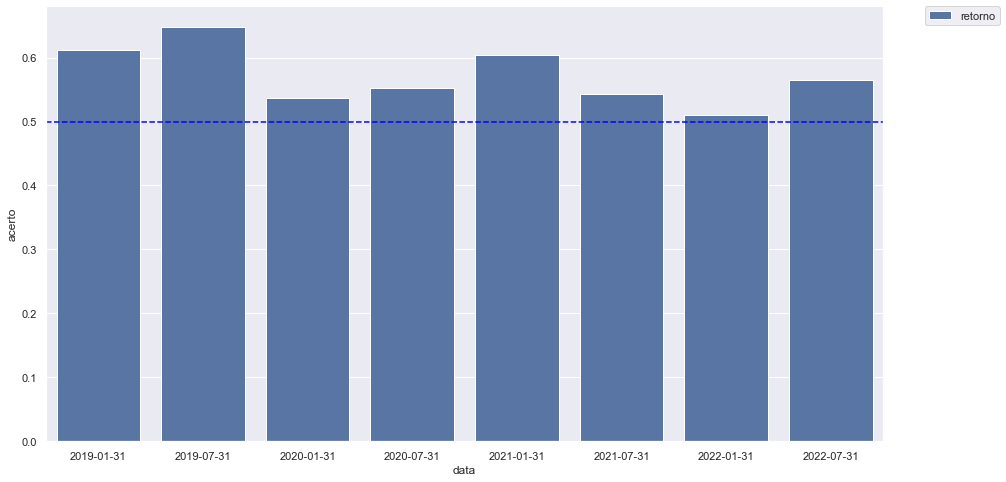

In [35]:
halfyear_accuracy = fechadas.set_index('open_date').resample('6M')[['e_lucro_bruto']].mean().reset_index()
halfyear_accuracy.columns = ['open_date', 'retorno']
halfyear_accuracy['open_date'] = halfyear_accuracy['open_date'].dt.date
halfyear_accuracy = halfyear_accuracy.melt(id_vars='open_date', value_name='acerto')

sns.barplot(x='open_date', y='acerto', hue='variable', data=halfyear_accuracy)
plt.axhline(y=0.5, color='blue', linestyle='--')
plt.xlabel('data')
# plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [36]:
halfyear_accuracy

,open_date,variable,acerto
0,2019-01-31,retorno,0.611111
1,2019-07-31,retorno,0.647619
2,2020-01-31,retorno,0.537037
3,2020-07-31,retorno,0.552083
4,2021-01-31,retorno,0.603448
5,2021-07-31,retorno,0.543478
6,2022-01-31,retorno,0.510204
7,2022-07-31,retorno,0.564706


In [37]:
fechadas

,date,open_date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,...,side,id,ratio_sem_custos,ratio,return,retorno_acumulado,return_sem_custos,retorno_acumulado_sem_custos,e_lucro_bruto,e_lucro_liquido
7,2019-05-06,2019-04-24,"(CCRO3, ECOR3)",close,11.718472,8.479366,1.192578,1.1845665497455284,1.289334,0.465580,...,upper,1,0.734308,0.723590,-0.006270,-0.051924,0.008449,-0.024121,False,False
12,2019-02-01,2019-01-28,"(BRML3, MULT3)",close,13.439225,24.385624,0.599995,VAR CLOSE,0.019772,0.321958,...,upper,2,1.841079,1.814511,0.005838,0.014003,0.020566,0.043565,True,True
19,2019-05-08,2019-04-29,"(BRML3, MULT3)",close,11.418350,23.022537,0.609782,0.6050452500556807,-0.783007,0.303903,...,lower,3,0.503282,0.495964,-0.028067,-0.039400,-0.013726,-0.011285,False,False
26,2019-06-14,2019-06-06,"(BRML3, MULT3)",close,13.185712,25.773151,0.591845,0.5839001178325625,-0.524460,0.318016,...,lower,4,0.519156,0.511607,-0.014439,-0.011640,0.000103,0.017288,True,False
32,2019-01-28,2019-01-18,"(B3SA3, BBAS3)",close,9.339474,39.616710,0.126603,0.13127538589045346,0.977604,0.230240,...,upper,5,4.304207,4.241857,-0.043956,-0.087231,-0.029903,-0.060568,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679,2022-02-16,2022-01-31,"(SOMA3, ALPA4)",close,13.384768,26.897661,0.213015,0.1962354716969698,1.604310,1.294916,...,upper,561,2.039910,2.009573,-0.042548,-0.019601,-0.028094,0.009433,True,False
3700,2022-06-06,2022-05-09,"(SOMA3, ASAI3)",close,11.021190,15.599025,0.811444,0.88996891081946,-3.451311,1.615629,...,lower,562,0.717518,0.706531,-0.049965,-0.033707,-0.035192,-0.004646,False,False
3702,2022-04-05,2022-04-04,"(VIIA3, CVCB3)",close,4.001387,17.405609,0.773178,VAR CLOSE,-3.501767,1.520897,...,lower,563,0.233218,0.229891,-0.092871,-0.092871,-0.066582,-0.066582,False,False
3707,2022-04-08,2022-04-04,"(VIIA3, LREN3)",close,3.574440,26.767631,0.645305,VAR CLOSE,-1.436871,1.164183,...,lower,565,0.135491,0.133536,-0.089497,-0.097280,-0.076165,-0.070963,False,False


In [38]:
display(fechadas.groupby(['setor', 'open_date']).e_lucro_bruto.mean().reset_index())

,setor,open_date,e_lucro_bruto
0,Alimentos e Bebidas,2020-01-23,0.0
1,Alimentos e Bebidas,2020-02-28,0.0
2,Alimentos e Bebidas,2020-04-16,0.0
3,Alimentos e Bebidas,2020-05-13,1.0
4,Alimentos e Bebidas,2020-08-24,1.0
...,...,...,...
429,Varejo,2022-05-09,0.5
430,Varejo,2022-05-18,0.0
431,Varejo,2022-06-02,1.0
432,Varejo,2022-06-03,1.0


Text(0, 0.5, 'acerto')

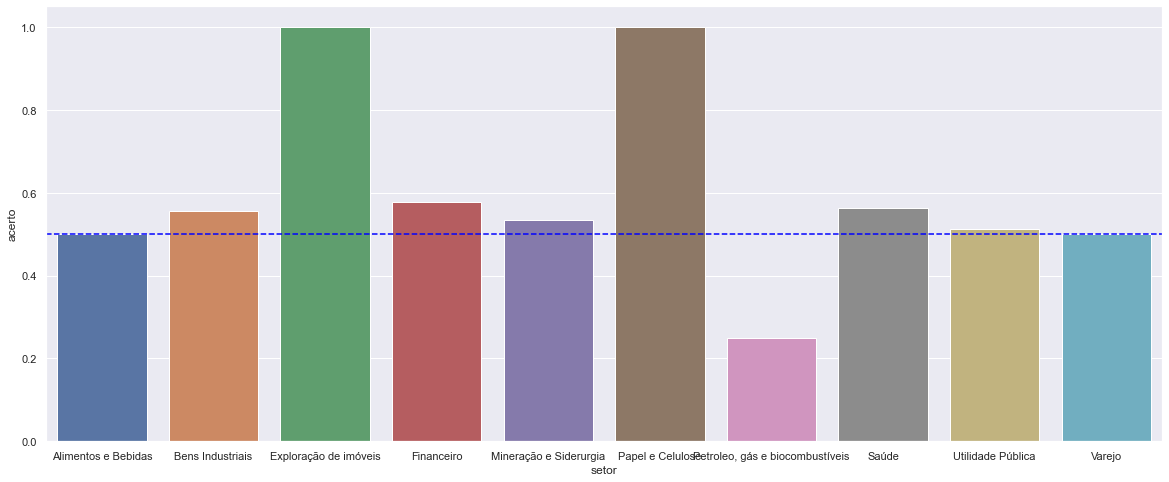

In [39]:
fechadas_agrupadas_semestre = fechadas.groupby(['setor', pd.Grouper(key='open_date', freq='1Y')]).e_lucro_bruto.mean().reset_index()

plt.figure(figsize=(20,8))

fechadas_agrupadas_semestre['open_date'] = pd.to_datetime(fechadas_agrupadas_semestre['open_date'])
fechadas_2020 = fechadas_agrupadas_semestre.set_index('open_date').loc['2020'].reset_index()
fechadas_2020['open_date'] = fechadas_2020.open_date.dt.date

sns.barplot(x='setor', y='e_lucro_bruto', data=fechadas_2020)
plt.axhline(y=0.5, color='blue', linestyle='--')

plt.ylabel('acerto')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [40]:
fechadas.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'))

,total_trades,gain_halflife
open_date,,
2019-01-31,18,0.611111
2019-07-31,105,0.647619
2020-01-31,54,0.537037
2020-07-31,96,0.552083
2021-01-31,58,0.603448
2021-07-31,46,0.543478
2022-01-31,49,0.510204
2022-07-31,85,0.564706


In [47]:
fechadas_halflife = fechadas.loc[(fechadas.days_open > fechadas.halflife) & (fechadas.beta_close!='VAR CLOSE')]
fechadas_stop_var = fechadas.loc[(fechadas.beta_close=='VAR CLOSE')]
fechadas_retorno = fechadas.loc[(abs(fechadas.last_residual) <= fechadas.close_limit) & (fechadas.beta_close!='VAR CLOSE') & (fechadas.days_open <= fechadas.halflife)]

In [48]:
# # fechadas_halflife = fechadas.loc[(fechadas.days_open > fechadas.halflife) & (fechadas.beta_close!='VAR CLOSE')]
# fechadas_stop_var = fechadas.loc[(fechadas.beta_close=='VAR CLOSE')]
# fechadas_retorno = fechadas.loc[(abs(fechadas.last_residual) <= fechadas.close_limit) & (fechadas.beta_close!='VAR CLOSE')]

In [49]:
todos_indices = fechadas_stop_var.index.tolist() + fechadas_halflife.index.tolist() + fechadas_retorno.index.tolist()

seen = set()
dupes = [x for x in todos_indices if x in seen or seen.add(x)]    

In [50]:
set(fechadas.index.tolist()) - set(todos_indices)

set()

In [51]:
fechadas.shape

(511, 35)

In [52]:
fechadas_retorno_semestre = fechadas_retorno.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_retorno_media = ('e_lucro_bruto', 'mean'),
)
fechadas_retorno_semestre['loss_retorno_media'] = 1-fechadas_retorno_semestre['gain_retorno_media']

fechadas_retorno_semestre

,total_trades,gain_retorno_media,loss_retorno_media
open_date,,,
2019-01-31,3,1.0,0.0
2019-07-31,11,1.0,0.0
2020-01-31,3,1.0,0.0
2020-07-31,12,1.0,0.0
2021-01-31,2,1.0,0.0
2021-07-31,4,1.0,0.0
2022-01-31,3,1.0,0.0
2022-07-31,9,1.0,0.0


In [53]:
fechadas_var_semestre = fechadas_stop_var.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_var = ('e_lucro_bruto', 'mean'),
)
fechadas_var_semestre['loss_var'] = 1-fechadas_var_semestre['gain_var']

fechadas_var_semestre

,total_trades,gain_var,loss_var
open_date,,,
2019-01-31,6,0.666667,0.333333
2019-07-31,20,0.800000,0.200000
2020-01-31,15,0.600000,0.400000
2020-07-31,49,0.428571,0.571429
2021-01-31,21,0.571429,0.428571
2021-07-31,8,0.500000,0.500000
2022-01-31,16,0.375000,0.625000
2022-07-31,45,0.555556,0.444444


In [54]:
halflife_semestre = fechadas_halflife.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'),
)

halflife_semestre['loss_halflife'] = 1-halflife_semestre['gain_halflife']

halflife_semestre

,total_trades,gain_halflife,loss_halflife
open_date,,,
2019-01-31,9,0.444444,0.555556
2019-07-31,74,0.554054,0.445946
2020-01-31,36,0.472222,0.527778
2020-07-31,35,0.571429,0.428571
2021-01-31,35,0.600000,0.400000
2021-07-31,34,0.500000,0.500000
2022-01-31,30,0.533333,0.466667
2022-07-31,31,0.451613,0.548387


# Resumo Pares

In [ ]:
fechadas_grouped = fechadas.groupby('sorted_pair').agg(
    trades = ('sorted_pair','count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    prazo_medio_operacao = ('days_open', 'mean'),
    retorno_bruto_acum = ('retorno_acumulado_sem_custos', 'sum'),
    retorno_liquidi_acum = ('retorno_acumulado', 'sum')
)

fechadas_grouped.sort_values(by=['trades', 'taxa_acerto'], ascending=False).head(15)